In [ ]:
%pip install ultralytics

### All required libraries

In [1]:
import cv2
import numpy as np
# from google.colab.patches import cv2_imshow
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt


### Extract CLAHE applied frames

In [2]:
# import cv2

clahe = cv2.createCLAHE(clipLimit=15.0, tileGridSize=(16, 16))

def apply_clahe(frame):
    hsv_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    h, s, v = hsv_img[:, :, 0], hsv_img[:, :, 1], hsv_img[:, :, 2]
    v = clahe.apply(v)
    hsv_img = np.dstack((h, s, v))
    frame = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)
    return frame

In [4]:
# import cv2

def frames_extraction(video_path, SEQUENCE_LENGTH):
    '''
    This function will extract the required frames from a video after preprocessing them.
    Args:
        video_path: The path of the video on the disk, whose frames are to be extracted.
        SEQUENCE_LENGTH: Number of frames you want to extract from the video
    Returns:
        frames_list: A list containing the preprocessed frames of the video.
    '''

    frames_list = []
    video = cv2.VideoCapture(video_path)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_window = max(int(frame_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_window)
        frame = video.read()[1]
        if frame is None:
            break
        frame = apply_clahe(frame)
        frames_list.append(frame)
    video.release()

    return frames_list


### Visualize

In [26]:
# from google.colab.patches import cv2_imshow

def visualize(frames_list):
  for frame in frames_list:
    plt.imshow(frame)
    plt.show()

In [27]:
frames_list = frames_extraction('F:\CS3501-Data_Science_and_Engineering_Project\Project Files\Human-Action-Recognition-in-the-dark\datasets\clips_v1.5\Drink\Drink_1_1.mp4', 3)

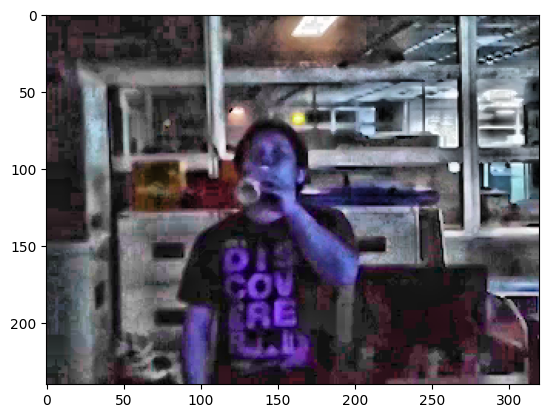

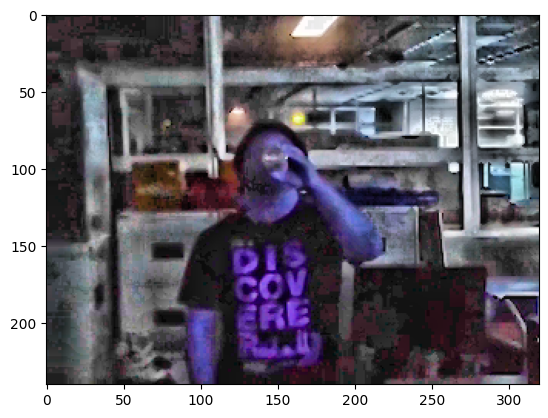

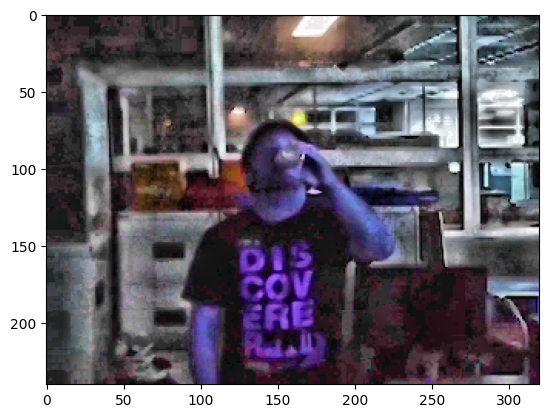

In [28]:
visualize(frames_list)

In [29]:
from PIL import Image

model = YOLO('yolov8n-pose.pt')
results = model(frames_list)
for i, r in enumerate(results):
  im_array = r.plot()  # plot a BGR numpy array of predictions
  im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
  im.show()  # show image
  im.save(f'result{i}.jpg')  # save image


0: 480x640 1 person, 1: 480x640 1 person, 2: 480x640 1 person, 235.2ms
Speed: 4.3ms preprocess, 78.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


### Key-point extraction

In [9]:
# import numpy as np

def calculate_euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [10]:
# from ultralytics import YOLO

model = YOLO('yolov8n-pose.pt')

def keypoint_detection(frames_list):

  prev_keypoints = None
  results = model(frames_list, stream=True)
  keypoints = []

  for result in results:
    keypoints_frame = None

    if len(result) > 0:
      keypoints_frame = result[0].keypoints.xyn.squeeze(0)

    if prev_keypoints is not None and keypoints_frame is not None:
      euclidean_distances = [calculate_euclidean_distance(prev_point, current_point)
                            for prev_point, current_point in zip(prev_keypoints, keypoints_frame)]
      keypoints.append(euclidean_distances)

    prev_keypoints = keypoints_frame if keypoints_frame is not None else prev_keypoints
  # keypoints = np.array(keypoints)
  if keypoints:
    keypoints = np.array(keypoints)
  else:
    keypoints = np.zeros((19,17))
  return keypoints


### Sample

In [5]:
frames_list = frames_extraction('F:\CS3501-Data_Science_and_Engineering_Project\Project Files\Human-Action-Recognition-in-the-dark\datasets\clips_v1.5\Drink\Drink_1_1.mp4', 20)

In [6]:
keypoints = keypoint_detection(frames_list)

NameError: name 'keypoint_detection' is not defined

In [13]:
print(keypoints)

[[  0.0095392    0.009115   0.0098765   0.0061308   0.0089249     0.01458   0.0075823    0.019152   0.0092408    0.016002    0.021221    0.014402           0           0           0           0           0]
 [  0.0097356    0.010018    0.010585   0.0054039    0.010402   0.0019527    0.019653    0.018878    0.018547     0.01342   0.0016308   0.0075718           0           0           0           0           0]
 [  0.0069071   0.0083051   0.0057406   0.0078914   0.0010103    0.012806   0.0073574    0.014175    0.024093     0.01363      0.0034   0.0056334           0           0           0           0           0]
 [   0.010319    0.015488   0.0020342    0.026641   0.0058226    0.016199     0.01173   0.0057618    0.016817    0.013288   0.0029233      1.0992           0           0           0           0           0]
 [  0.0051854   0.0051605   0.0041905    0.010236    0.010779   0.0088547    0.021048    0.013309    0.035023      0.0279    0.013075           0           0           0   

### Create dataset

In [14]:
# import os
# import numpy as np

In [17]:
# Function to assign labels to action categories
def get_action_label(action_folder):
  action_categories = [
    'Drink', 'Jump', 'Pick','Pour', 'Push', 'Run', 'Sit', 'Stand', 'Turn', 'Walk', 'Wave'
  ]
  return action_categories.index(action_folder)


In [ ]:
# Define the path to your dataset root directory
dataset_root = 'F:\CS3501-Data_Science_and_Engineering_Project\Project Files\Human-Action-Recognition-in-the-dark\datasets\clips_v1.5'  # Replace with your dataset path

# Initialize lists to store processed data and labels
data_list = []
label_list = []

# Loop through subfolders in the dataset root directory
for action_folder in os.listdir(dataset_root):
  action_folder_path = os.path.join(dataset_root, action_folder)

  # Ensure that the path is a directory
  if os.path.isdir(action_folder_path):
    print(f"PROCESSING VIDEOS IN FOLDER: {action_folder}")
    n = 0

    # Process each video in the subfolder
    for i, video_filename in enumerate(os.listdir(action_folder_path)):
      if (i % 50 == 0):
        print(f"STILL PROCESSING VIDEOS IN FOLDER: {action_folder}")
        print(f"PROCESSED VIDEOS SO FAR: {i},{n}")
      video_path = os.path.join(action_folder_path, video_filename)
      # print(video_filename)

      # Extract frames from the video
      frames_list = frames_extraction(video_path, SEQUENCE_LENGTH=20)

      # Detect keypoints and calculate distances
      keypoints = keypoint_detection(frames_list)

      # Assign a label based on the action category
      label = get_action_label(action_folder)

      # Append the data and label to the lists
      data_list.append(keypoints)
      label_list.append(label)
      n += 1

# Convert data and labels to NumPy arrays
data_array = np.array(data_list)
label_array = np.array(label_list)

# Save the processed data and labels to file (optional)
np.save('processed_data.npy', data_array)
np.save('labels.npy', label_array)


In [ ]:
# {
# 	"name": "ValueError",
# 	"message": "setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6207,) + inhomogeneous part.",
# 	"stack": "---------------------------------------------------------------------------
# ValueError                                Traceback (most recent call last)
# f:\\CS3501-Data_Science_and_Engineering_Project\\Project Files\\Human-Action-Recognition-in-the-dark\
# otebooks\\Another.ipynb Cell 22 line 4
#      <a href='vscode-notebook-cell:/f%3A/CS3501-Data_Science_and_Engineering_Project/Project%20Files/Human-Action-Recognition-in-the-dark/notebooks/Another.ipynb#X30sZmlsZQ%3D%3D?line=36'>37</a>       n += 1
#      <a href='vscode-notebook-cell:/f%3A/CS3501-Data_Science_and_Engineering_Project/Project%20Files/Human-Action-Recognition-in-the-dark/notebooks/Another.ipynb#X30sZmlsZQ%3D%3D?line=38'>39</a> # Convert data and labels to NumPy arrays
# ---> <a href='vscode-notebook-cell:/f%3A/CS3501-Data_Science_and_Engineering_Project/Project%20Files/Human-Action-Recognition-in-the-dark/notebooks/Another.ipynb#X30sZmlsZQ%3D%3D?line=39'>40</a> data_array = np.array(data_list)
#      <a href='vscode-notebook-cell:/f%3A/CS3501-Data_Science_and_Engineering_Project/Project%20Files/Human-Action-Recognition-in-the-dark/notebooks/Another.ipynb#X30sZmlsZQ%3D%3D?line=40'>41</a> label_array = np.array(label_list)
#      <a href='vscode-notebook-cell:/f%3A/CS3501-Data_Science_and_Engineering_Project/Project%20Files/Human-Action-Recognition-in-the-dark/notebooks/Another.ipynb#X30sZmlsZQ%3D%3D?line=42'>43</a> # Save the processed data and labels to file (optional)

# ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6207,) + inhomogeneous part."
# }

In [22]:
data_array = np.array(data_list)
label_array = np.array(label_list)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6207,) + inhomogeneous part.